### Import Data

GBTC.csv contains GBTC's price and volume on a 15-minute interval. 

XBT.csv contains only the price of XBT with the same frequency. Volume is absent because bitcoins are traded across numerous exchanges and there's no such aggregated volume figure. 

Both datasets span a time frame from 2017-6-21 to 2017-12-22, 15:45 end time.  

In [1]:
import pandas as pd
import numpy as nphttp://localhost:8890/notebooks/Research%20Projects/GBTC_research.ipynb#
import matplotlib.pyplot as plt
from datetime import datetime, date, time
% matplotlib inline 

In [2]:
df_GBTC = pd.read_csv('GBTC.csv')
df_XBT = pd.read_csv('XBT.csv')

### Descriptive Analysis

In [3]:
df_GBTC.describe();
df_GBTC.head()

,Date_time,Volume,Price
0,6/21/17 9:30,3584,460.00
1,6/21/17 9:45,2946,454.90
2,6/21/17 10:00,224,456.00
3,6/21/17 10:15,697,452.25
4,6/21/17 10:30,550,440.00


In [4]:
df_XBT.describe();
df_XBT.head()

,Date_time,Price
0,6/21/17 0:00,2745.7000
1,6/21/17 0:15,2757.8179
2,6/21/17 0:30,2755.8149
3,6/21/17 0:45,2779.7600
4,6/21/17 1:00,2758.3452


In [5]:
# now you will notice Date_time is stored as a string type, which we will have to change into timestamp 
type(df_GBTC.Date_time[0])

str

#### Change Date_time into a timestamp series

In [6]:
df_GBTC.Date_time = pd.to_datetime(df_GBTC.Date_time) 
df_XBT.Date_time = pd.to_datetime(df_XBT.Date_time)

### Now we get some plots
Note the price levels are not comparable, as XBT is almost 10 times as high, so we will need to normalize them for comparison

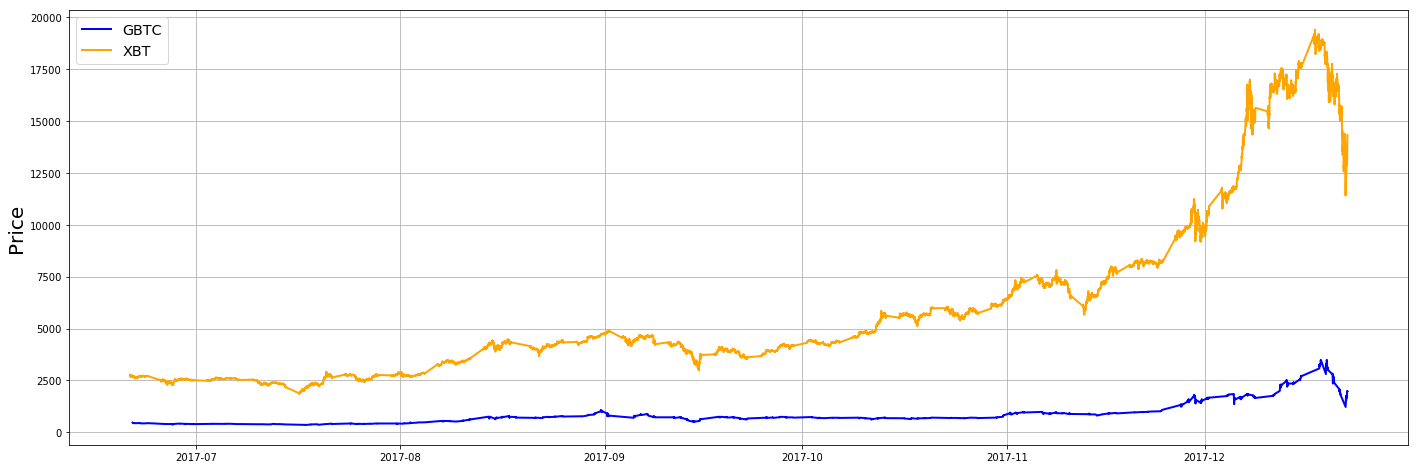

In [7]:
fig, ax0 = plt.subplots(figsize = (24,8))

ax0.plot(df_GBTC.Date_time.values, df_GBTC.Price, label = 'GBTC', color = 'blue', lw =2)
ax0.plot(df_XBT.Date_time.values, df_XBT.Price, label = 'XBT', color = 'orange', lw =2)
ax0.set_ylabel('Price', fontsize=20, color="black")
ax0.legend(loc=2, fontsize = 'x-large')
ax0.grid(True)

Putting together the volume and price of GBTC requires a bit formatting on the datetime distribution. 

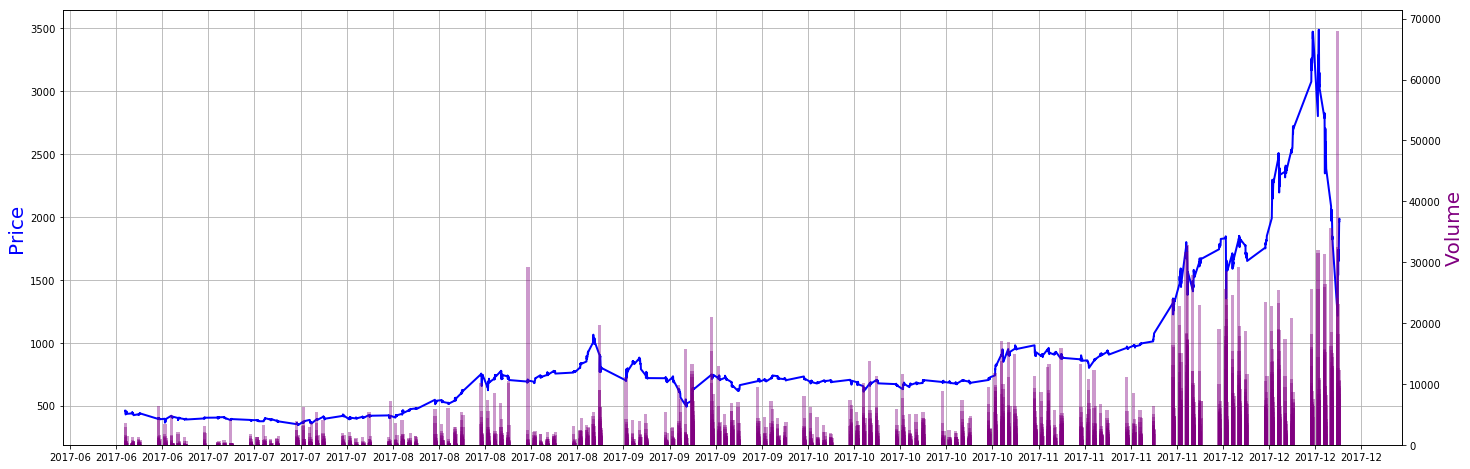

In [8]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize = (24,8))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) ## format the display form
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())  ## format the interval distance 

ax1.plot(df_GBTC.Date_time.values, df_GBTC.Price,  color = 'blue', lw =2)
ax1.set_ylabel('Price', fontsize=20, color="blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(df_GBTC.Date_time.values, df_GBTC.Volume, width=0.5, align='center', color = 'purple', alpha = 0.4)
ax2.set_ylabel('Volume', fontsize=20, color="purple")

### Data Preprocessing

First, I remove the dates in XBT that are non-trading days because GBTC only trades on regular trading days.

Then I adjust XBT's price by a factor such that it's commensurate with GBTC's NAV value. 

I then split XBT dataset into intrady (9:30-15:45), when GBTC trades, and overnight (16:00-9:15) when market is closed.

In [9]:
# Remove XBT non-trading period data
concurrent_dates = df_GBTC.Date_time.dt.date.unique()
df_XBT = df_XBT[df_XBT.Date_time.dt.date.isin(concurrent_dates)]   

In [10]:
# Use 12/21 16:00 (market close time) as the reference point for NAV calculation

NAV_12_21_close = 1482.64 # this is the NAV as of 12-21 4pm
XBT_12_21_close = df_XBT.Price[df_XBT.Date_time == pd.to_datetime('2017-12-21 16:00:00')].values
Adjust_factor = NAV_12_21_close/XBT_12_21_close
df_XBT['NAV_Adj_XBT'] = df_XBT.Price*Adjust_factor

In [11]:
# Double check if the values are correctly converted 
df_XBT.NAV_Adj_XBT[df_XBT.Date_time == pd.to_datetime('2017-12-21 16:00:00')] == NAV_12_21_close

12833    True
Name: NAV_Adj_XBT, dtype: bool

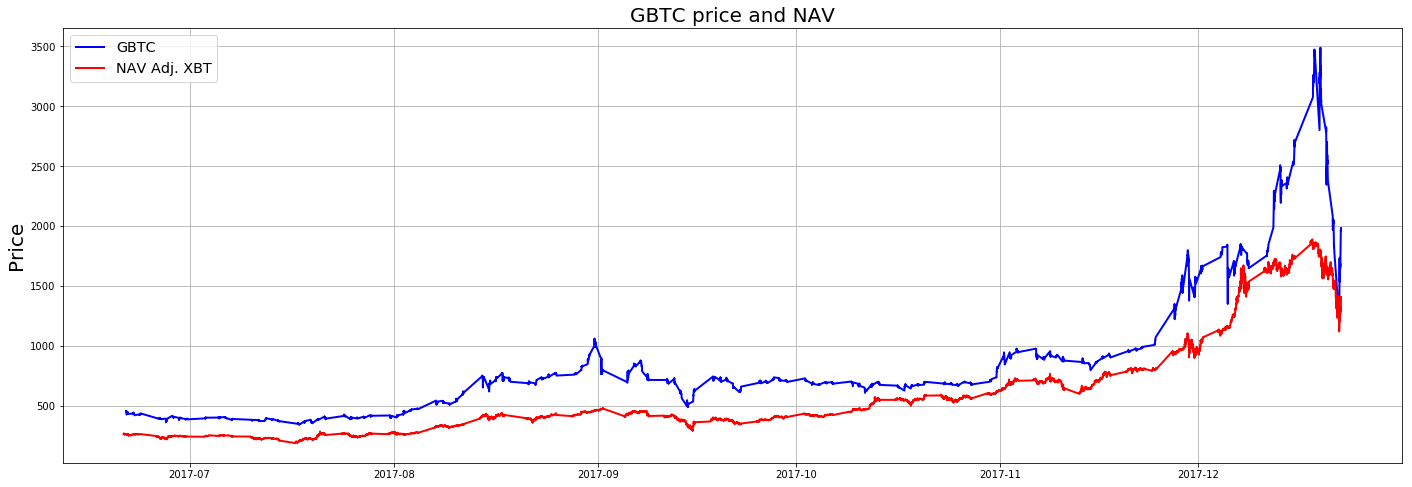

In [12]:
fig, ax = plt.subplots(figsize = (24,8))

ax.plot(df_GBTC.Date_time.values, df_GBTC.Price, label = 'GBTC', color = 'blue', lw =2)
ax.plot(df_XBT.Date_time.values, df_XBT.NAV_Adj_XBT, label = 'NAV Adj. XBT', color = 'red', lw =2)
ax.set_ylabel('Price', fontsize=20, color="black")
ax.legend(loc=2, fontsize = 'x-large')
ax.set_title('GBTC price and NAV', loc='center', fontsize = 20)
ax.grid(True)

In [13]:
# Now, the last step is to split df_XBT into overnight and intraday, and merge the intraday set with the GBTC dataset

tmp1 = df_XBT[df_XBT.Date_time.dt.strftime('%H:%M:%S').between('00:00:00','09:15:00')]
tmp2 = df_XBT[df_XBT.Date_time.dt.strftime('%H:%M:%S').between('16:00:00','23:45:00')]
df_XBT_overnight = pd.concat([tmp1, tmp2], axis=0)
df_XBT_overnight.sort_values(by='Date_time',ascending = True, inplace=True)
df_XBT_overnight.rename(index = str, columns={'Price':'Price_XBT_unadj', 'NAV_Adj_XBT':'Adj_NAV'})

df_XBT_overnight.head() # make sure the truncation was done correctly 

,Date_time,Price,NAV_Adj_XBT
0,2017-06-21 00:00:00,2745.7000,270.283269
1,2017-06-21 00:15:00,2757.8179,271.476140
2,2017-06-21 00:30:00,2755.8149,271.278967
3,2017-06-21 00:45:00,2779.7600,273.636093
4,2017-06-21 01:00:00,2758.3452,271.528047


In [14]:
# It's also necessary to create columns the track how spread changes. In this case, I created three new columns, 
    # spread = dollar value of GBTC spread
    # spread_pct = spread%, denoting spread/NAV
    # spread_chg = change in spread% 
df_merged = pd.merge(df_GBTC, df_XBT, how= 'inner', on = 'Date_time')
df_merged.rename(index = str, columns={'Price_x': 'Price_GBTC', 'Price_y': 'Price_XBT_unadj', 'NAV_Adj_XBT':'Adj_NAV'}, inplace=True)
df_merged['Spread'] = df_merged.Price_GBTC - df_merged.Adj_NAV
df_merged['Spread_pct'] = df_merged.Spread / df_merged.Adj_NAV

df_merged.head(5)

,Date_time,Volume,Price_GBTC,Price_XBT_unadj,Adj_NAV,Spread,Spread_pct
0,2017-06-21 09:30:00,3584,460.00,2730.3799,268.775178,191.224822,0.711468
1,2017-06-21 09:45:00,2946,454.90,2710.0684,266.775739,188.124261,0.705178
2,2017-06-21 10:00:00,224,456.00,2720.0269,267.756041,188.243959,0.703043
3,2017-06-21 10:15:00,697,452.25,2701.2800,265.910620,186.339380,0.700759
4,2017-06-21 10:30:00,550,440.00,2680.5066,263.865712,176.134288,0.667515


In [15]:
## create session() function to divide time periods into open, midday, close buckets

def session(t):
    if  time(9,15) < t < time(11,0):
        return 'Early open'
    elif time(15,0) < t < time(16,0):
        return 'Closing'
    else:
        return 'Midday'

In [16]:
# Next, I added several characteristic variables such as month and time range, to explore how spread changes 
# over months and in certain time periods of the day

df_merged['Month'] = df_merged.Date_time.dt.month
df_merged['Session'] = df_merged.Date_time.dt.time.apply(lambda x: session(x))
df_merged.head()

,Date_time,Volume,Price_GBTC,Price_XBT_unadj,Adj_NAV,Spread,Spread_pct,Month,Session
0,2017-06-21 09:30:00,3584,460.00,2730.3799,268.775178,191.224822,0.711468,6,Early open
1,2017-06-21 09:45:00,2946,454.90,2710.0684,266.775739,188.124261,0.705178,6,Early open
2,2017-06-21 10:00:00,224,456.00,2720.0269,267.756041,188.243959,0.703043,6,Early open
3,2017-06-21 10:15:00,697,452.25,2701.2800,265.910620,186.339380,0.700759,6,Early open
4,2017-06-21 10:30:00,550,440.00,2680.5066,263.865712,176.134288,0.667515,6,Early open


### Let's see how spread% varies with Month,  Session and Volume

*I removed the month of June for consistency purpose*

In [17]:
import seaborn as sns

**Spread% distribution:**
The overall distribution looks like multi-modal (multiple peaks)

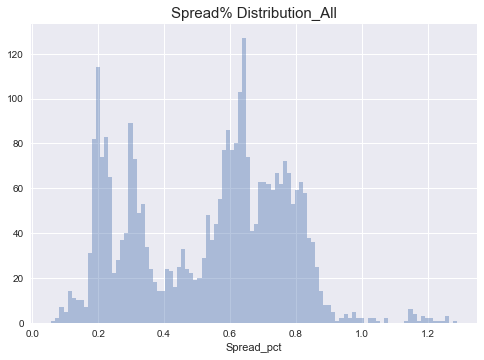

In [39]:
plt.title('Spread% Distribution_All', fontsize = 15)
sns.distplot(df_merged.Spread_pct,bins= 100,kde=False)

Clearly each month possesses a unique distribution, and is also multi-modal.

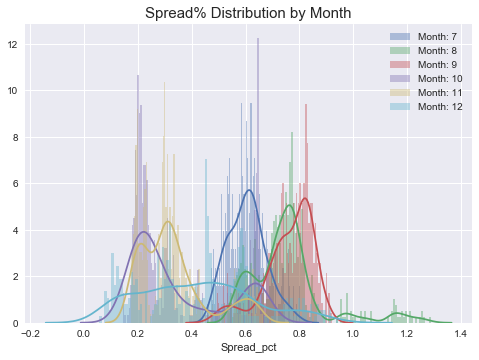

In [49]:
# plt.figure(figsize=(20,8))
plt.title('Spread% Distribution by Month', fontsize = 15)

for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    sns.distplot(df_tmp.Spread_pct, bins = 100, label ='Month: '+str(m))
    plt.legend(loc=0)

Box plots indicate a constantly shifting mean, and widening standard deviation after September. Potentially lower means are observed for the period October-December

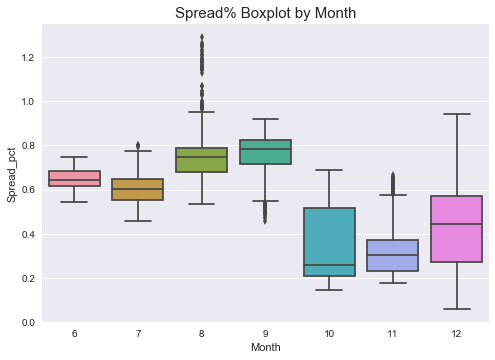

In [103]:
plt.title('Spread% Boxplot by Month', fontsize = 15)
sns.boxplot(x= 'Month', y='Spread_pct', data=df_merged)

The individual distplots don't seem to imply any trends

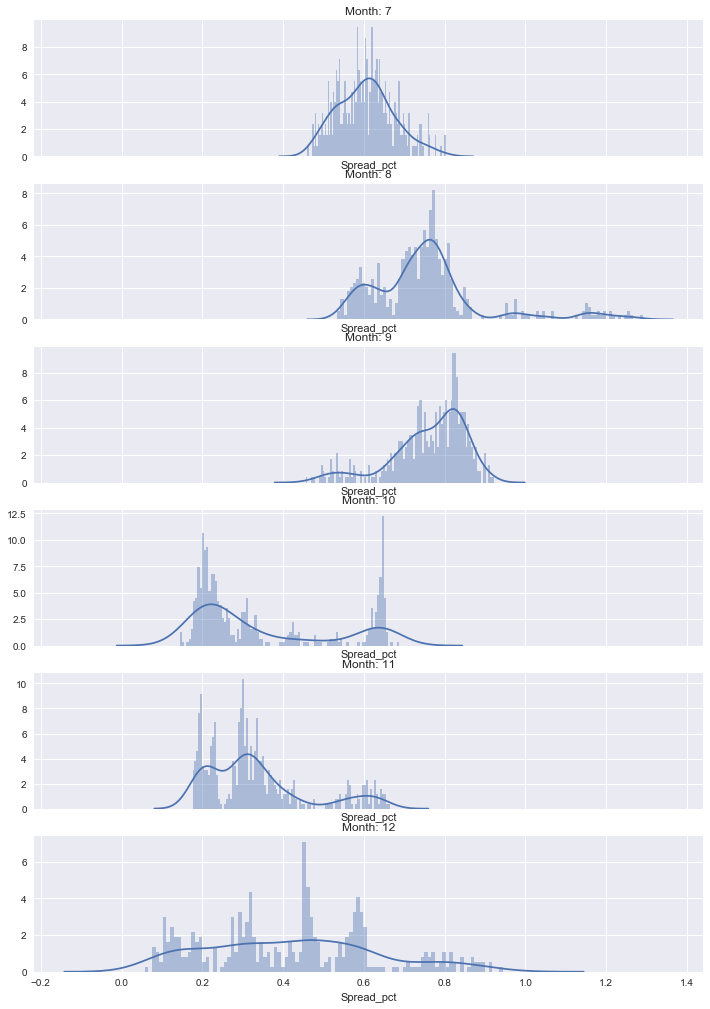

In [50]:
fig, ax = plt.subplots(6, 1, sharex=True, figsize = (12,17.5)) 
for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    sns.distplot(df_tmp.Spread_pct, bins = 100, label ='Month: '+str(m), ax=ax[m-7])
    ax[m-7].set_title('Month: '+str(m) )    

** By Session: **
There doesn't seem to be any material differences across three sessions, except that Spread% change is less dispersed at closing than is in the midday or at open, which is a normal pattern in stocks trading. 

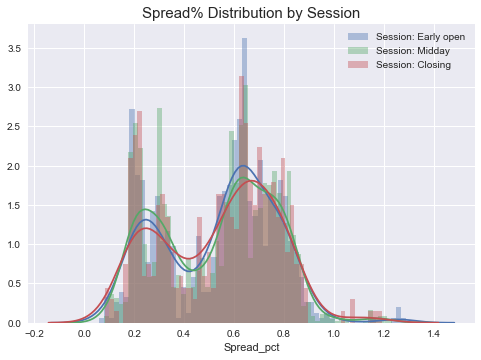

In [51]:
# plt.figure(figsize=(20,8))
plt.title('Spread% Distribution by Session', fontsize = 15)

sessions = ['Early open', 'Midday', 'Closing']
for s in sessions:
    df_tmp = df_merged[df_merged.Session == s]
    sns.distplot(df_tmp.Spread_pct, bins = 60, label ='Session: '+s)
    plt.legend(loc=0)

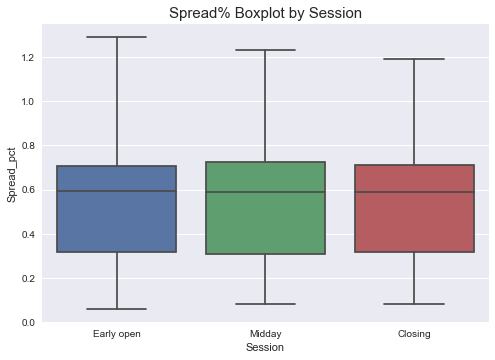

In [107]:
plt.title('Spread% Boxplot by Session', fontsize = 15)
sns.boxplot(x= 'Session', y='Spread_pct', data=df_merged)

**Let's see if and how will Volume factor in**

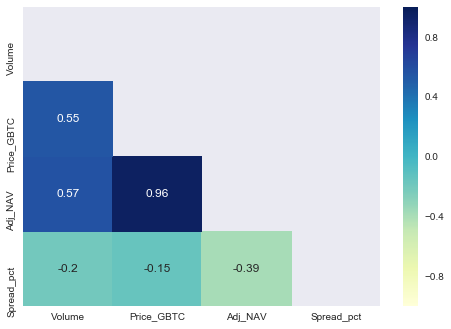

In [86]:
df_tmp = df_merged[['Volume','Price_GBTC', 'Adj_NAV', 'Spread_pct']]
matrix_temp = df_tmp.corr()
mask = np.zeros_like(matrix_temp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(matrix_temp,mask = mask, annot=True, cmap="YlGnBu")

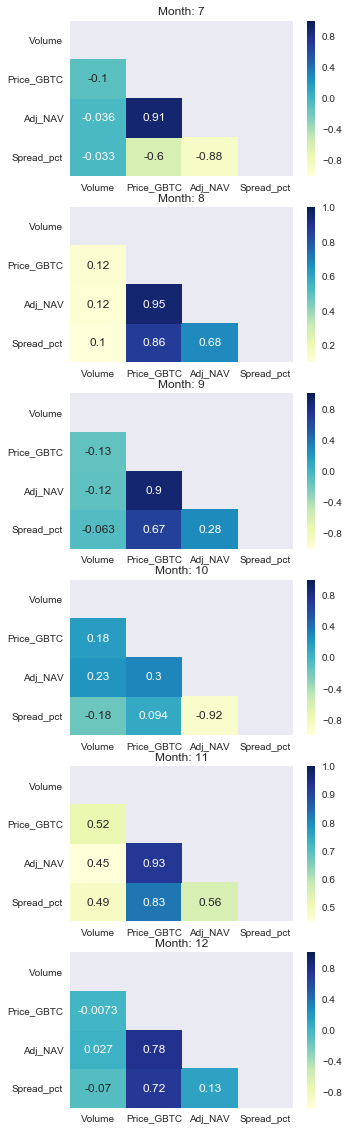

In [82]:
fig, ax = plt.subplots(6, 1, figsize = (5,20)) 

for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    df_tmp = df_tmp[['Volume','Price_GBTC', 'Adj_NAV', 'Spread_pct']]
    matrix_temp = df_tmp.corr()
    mask = np.zeros_like(matrix_temp, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(matrix_temp,annot=True, mask=mask, ax=ax[m-7], cmap="YlGnBu")
    ax[m-7].set_title('Month: '+str(m) )    

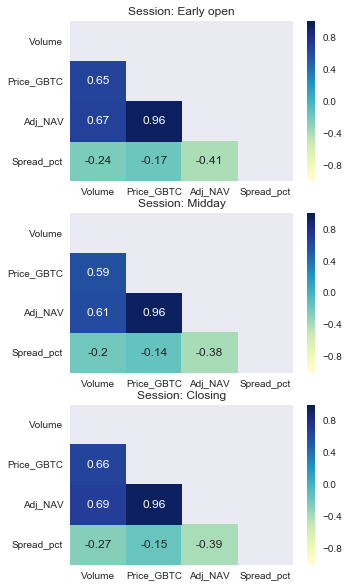

In [85]:
fig, ax = plt.subplots(3, 1, figsize = (5,10)) 
sessions = ['Early open', 'Midday', 'Closing']
for i in range(0,3):
    df_tmp = df_merged[df_merged.Session == sessions[i]]
    df_tmp = df_tmp[['Volume','Price_GBTC', 'Adj_NAV', 'Spread_pct']]
    matrix_temp = df_tmp.corr()
    mask = np.zeros_like(matrix_temp, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(matrix_temp,annot=True, mask=mask, ax=ax[i], cmap="YlGnBu")
    ax[i].set_title('Session: '+sessions[i] ) 

Again, Session doesn't account for the change in Spread%, nor does it matter on how Volume changes. 

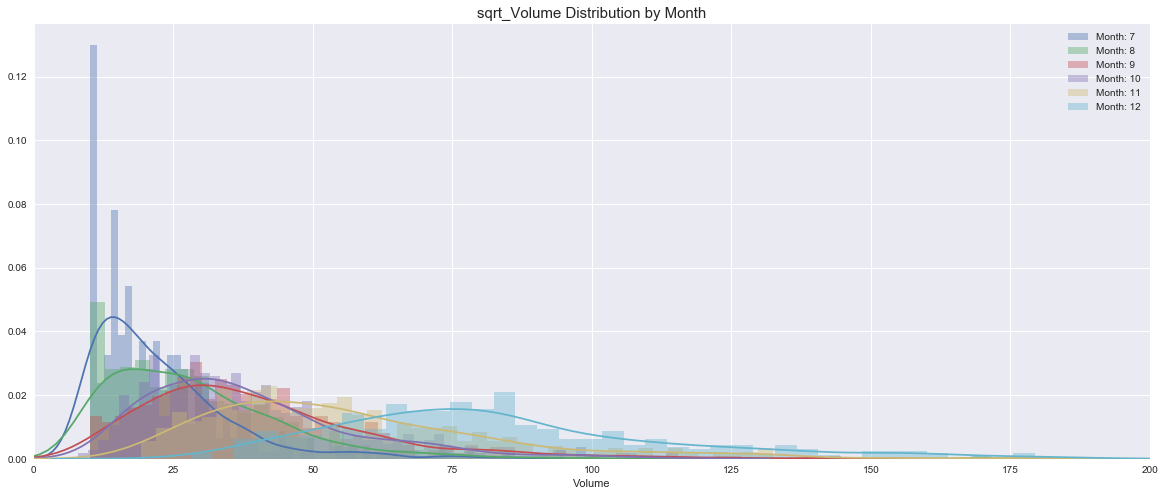

In [102]:
plt.figure(figsize=(20,8))
plt.xlim(0,200)
plt.title('sqrt_Volume Distribution by Month', fontsize = 15)

for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    sns.distplot(np.sqrt(df_tmp.Volume), bins = 60, label ='Month: '+str(m))
    plt.legend(loc=0)

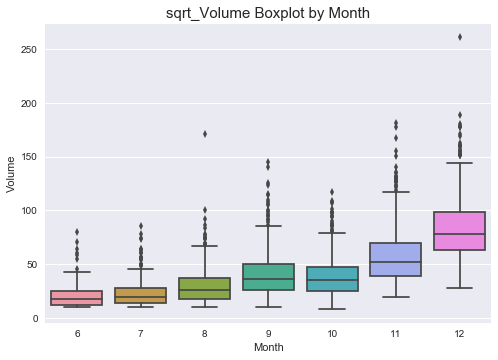

In [104]:
plt.title('sqrt_Volume Boxplot by Month', fontsize = 15)
sns.boxplot(x= 'Month', y=np.sqrt(df_merged.Volume), data=df_merged)

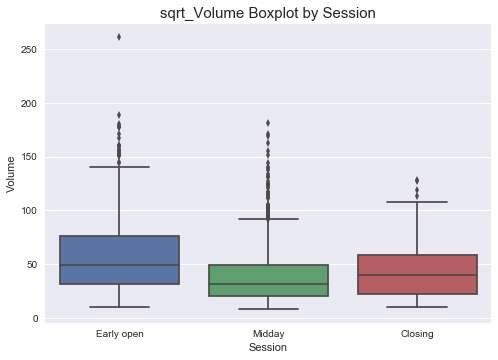

In [112]:
plt.title('sqrt_Volume Boxplot by Session', fontsize = 15)
sns.boxplot(x= 'Session', y=np.sqrt(df_merged.Volume), data=df_merged)

### Observations
> There's no material difference in Spread% among three sessions
> As is usually the case with equity markets. Volume is high at opening, followed by closing, then midday.
> What is interesting, however, is the distribution plots of Spread% exhibit bimodal distribution, i.e. two distinctive apex.

In [ ]:
fig, ax1 = plt.subplots(figsize = (24,8))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) ## format the display form
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())  ## format the interval distance 

ax1.plot(df_GBTC.Date_time.values, df_GBTC.Price,  color = 'blue', lw =2)
ax1.set_ylabel('Price', fontsize=20, color="blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(df_GBTC.Date_time.values, df_GBTC.Volume, align='center', color = 'purple', alpha = 0.4)
ax2.set_ylabel('Volume', fontsize=20, color="purple")

ax.set_xticks(range(0,len(weekday_quotes),5))
ax.set_xticklabels([mdates.num2date(quotes[index][0]).strftime('%b-%d') for index in ax.get

url: https://stackoverflow.com/questions/10529492/how-do-i-plot-only-weekdays-using-pythons-matplotlib-candlestick

plot the weekday x-axis

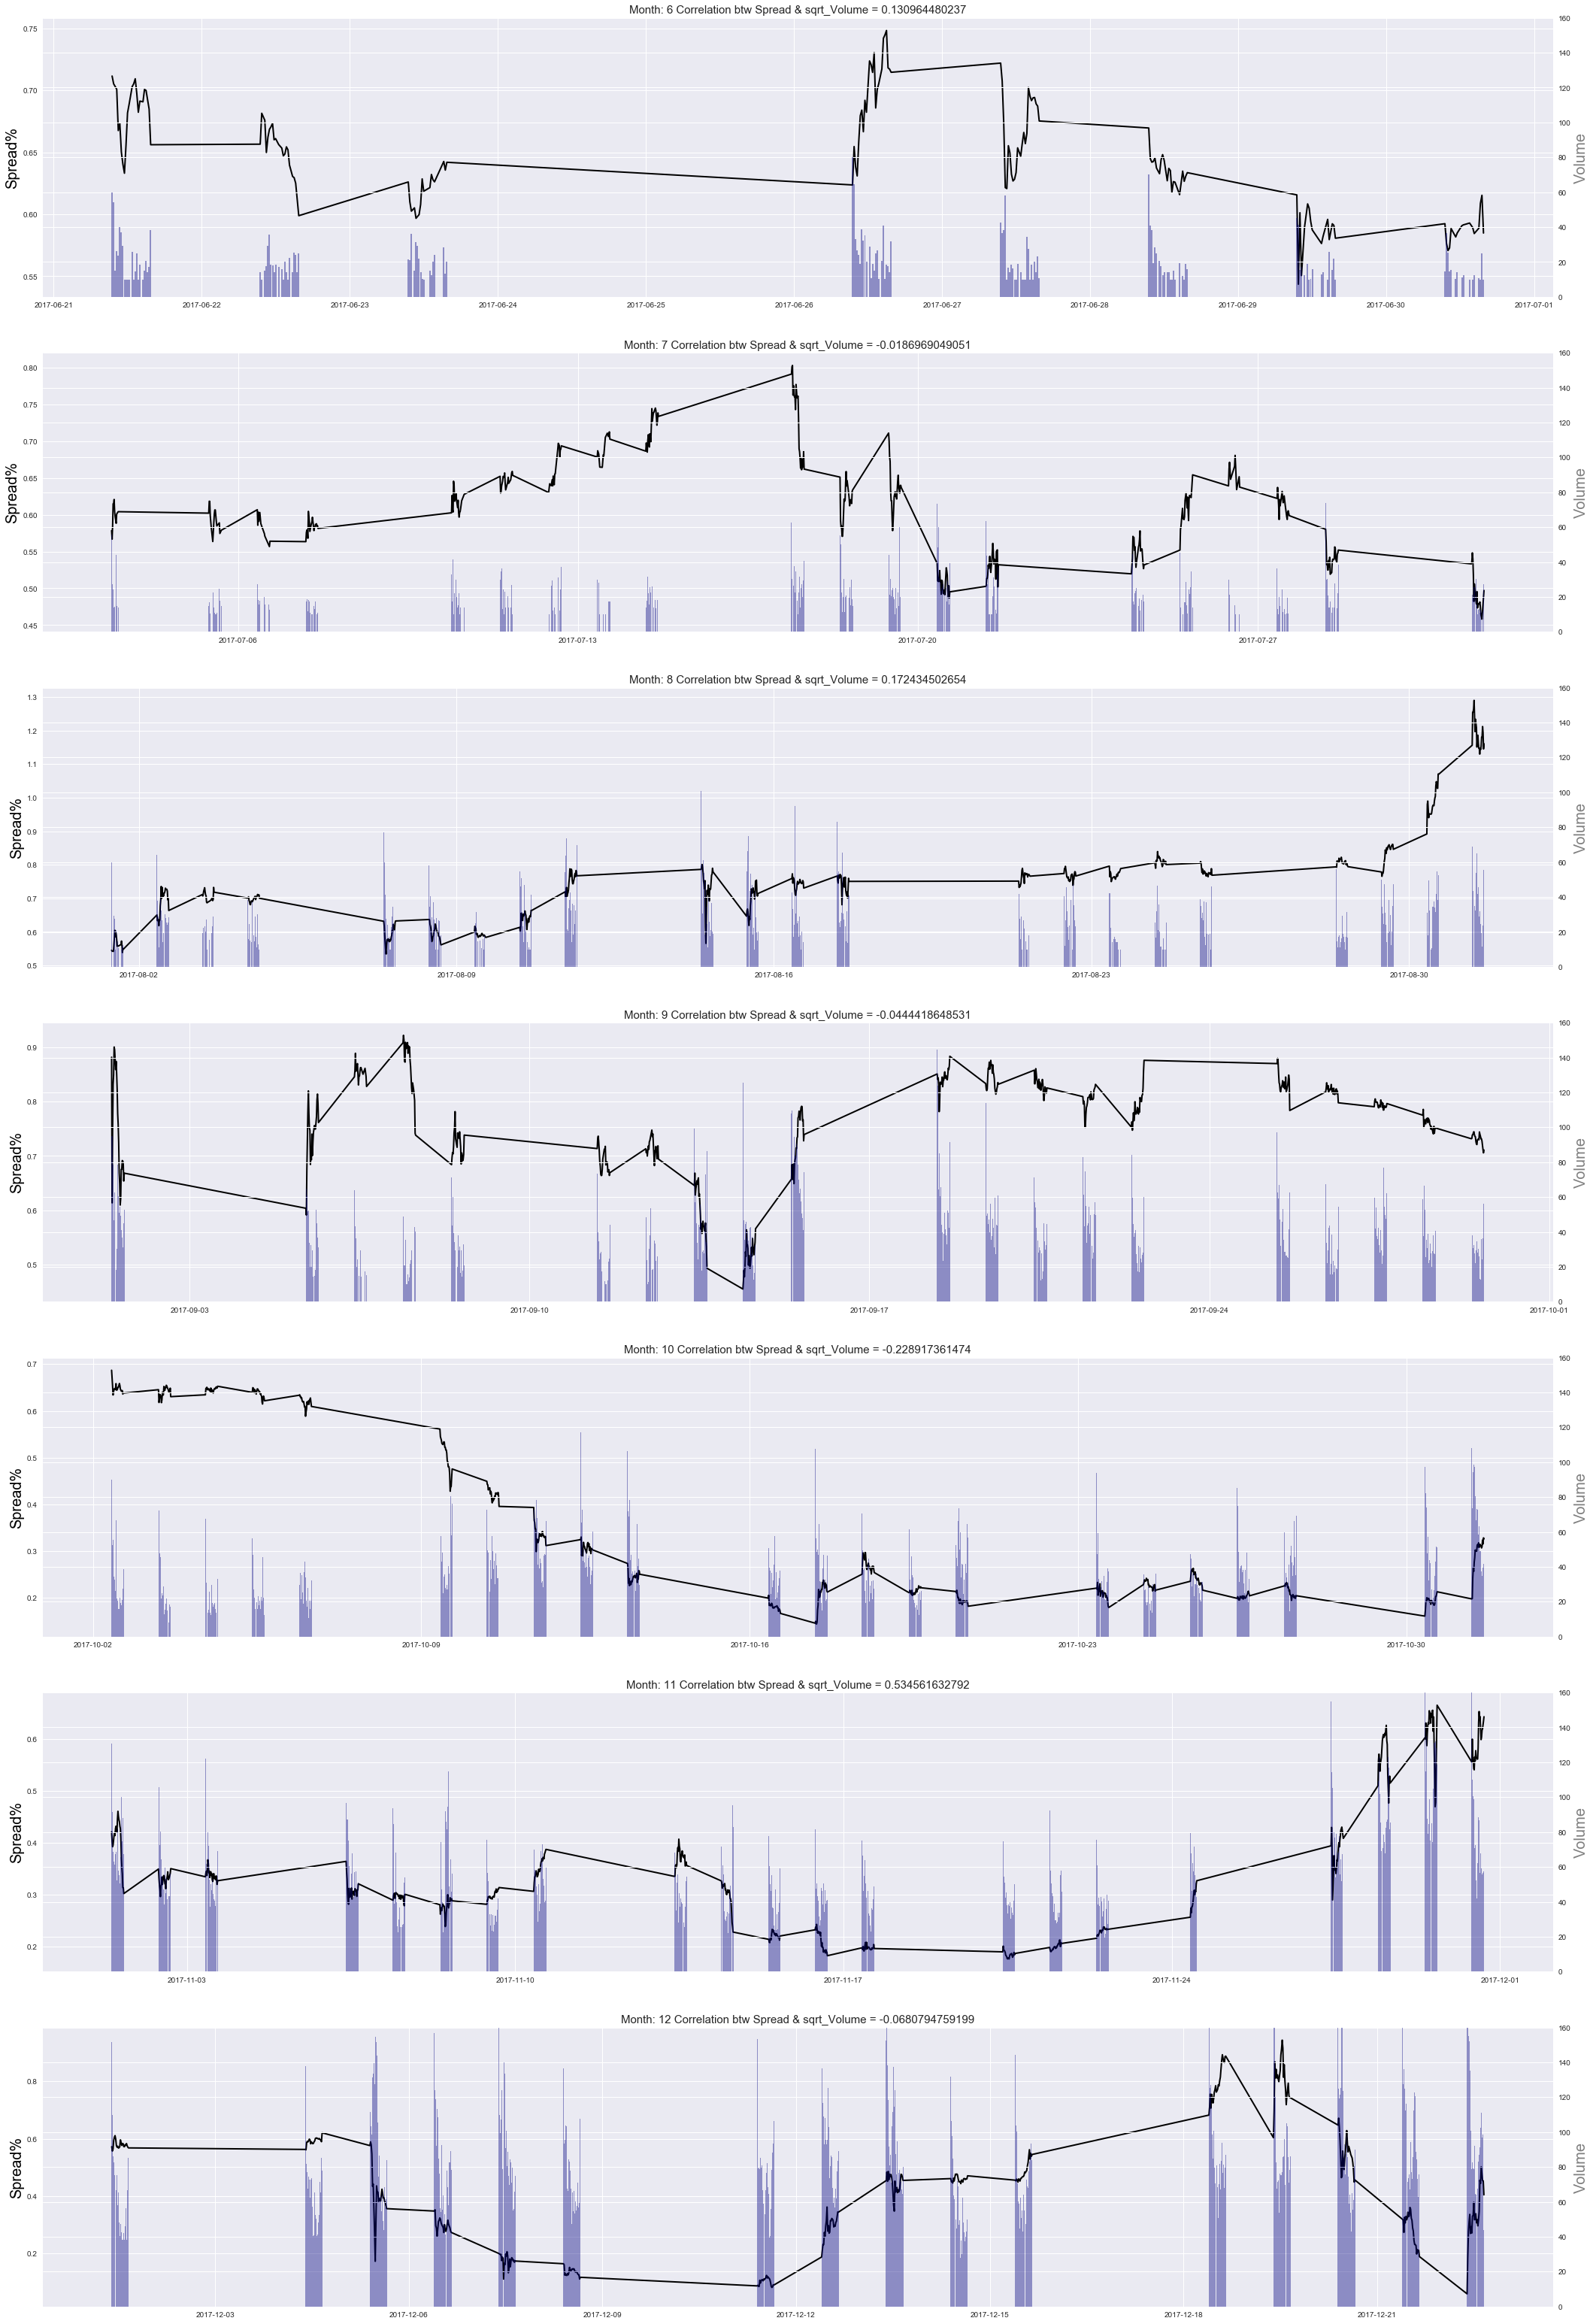

Now we have two new datasets, df_merged, which encompasses GBTC and NAV values, and df_XBT_overnight, which contains XBT and NAV values during market close time periods

### Plotly

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode()
# import cufflinks as cf
# print(cf.__version__)
# cf.go_offline()

> url: https://www.reddit.com/r/IPython/comments/3tibc8/tip_on_how_to_run_plotly_examples_in_offline_mode/


trace_GBTC = Scatter(
                x=df_merged.Date_time,
                y=df_merged.Price_GBTC,
                name = "GBTC Intraday Price",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_NAV = Scatter(
                x=df_merged.Date_time,
                y=df_merged.Adj_NAV,
                name = "Adjusted NAV",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

data = [trace_GBTC,trace_NAV]

layout = dict(
    title = "Spread Chart of GBTC vs NAV",
    height = 600,
    width = 800,
    xaxis = dict(
        range = ['2017-06-21','2017-12-22'])
)

fig = dict(data=data, layout=layout)
iplot(fig,kind='spread')

